In [1]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

class SimpleImageProcessor:
    def __init__(self, reference_width=1.0, min_size=30, max_size=100):
        self.reference_width = reference_width
        self.min_size = min_size
        self.max_size = max_size

        self.bins = {
            '0-6mm': 0,
            '6-8mm': 0,
            '8+mm': 0
        }

    def midpoint(self, ptA, ptB):
        return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

    def process_image(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)
        processed = cv2.Canny(gray, 50, 100)
        processed = cv2.dilate(processed, None, iterations=1)
        processed = cv2.erode(processed, None, iterations=1)
        return processed

    def calculate_size(self, box, pixels_per_metric):
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = self.midpoint(tl, tr)
        (blbrX, blbrY) = self.midpoint(bl, br)
        (tlblX, tlblY) = self.midpoint(tl, bl)
        (trbrX, trbrY) = self.midpoint(tr, br)

        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        if pixels_per_metric is None and dB != 0:
            pixels_per_metric = dB / self.reference_width

        if pixels_per_metric is None or pixels_per_metric == 0:
            return (0, 0), pixels_per_metric  # Avoid division by zero

        dimA = dA / pixels_per_metric
        dimB = dB / pixels_per_metric

        return (dimA, dimB), pixels_per_metric

    def draw_and_label(self, image, box, dimensions):
        cv2.drawContours(image, [box.astype("int")], -1, (0, 255, 0), 1)
        dimA, dimB = dimensions
        if dimA > 0 and dimB > 0:
            cv2.putText(image, "{:.1f}mm".format(dimA), (int(box[0][0]), int(box[0][1] - 10)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        return image

    def classify_size(self, size):
        if size > 8:
            self.bins['8+mm'] += 1
        elif size > 6:
            self.bins['6-8mm'] += 1
        else:
            self.bins['0-6mm'] += 1

    def process_image_file(self, image_path):
        image = cv2.imread(image_path)
        processed = self.process_image(image)

        cnts, _ = cv2.findContours(processed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        pixels_per_metric = None
        for c in cnts:
            if cv2.contourArea(c) < 10:  # Skip small contours
                continue

            box = cv2.minAreaRect(c)
            box = cv2.boxPoints(box)
            box = np.array(box, dtype="int")
            box = np.array(sorted(box, key=lambda x: (x[0], x[1])))  # Sort points for consistent order

            (dimA, dimB), pixels_per_metric = self.calculate_size(box, pixels_per_metric)

            if self.min_size < max(dimA, dimB) < self.max_size:
                self.classify_size(max(dimA, dimB))
                image = self.draw_and_label(image, box, (dimA, dimB))

        # Show the processed image with contours and labels
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Processed Image with Size Buckets')
        plt.axis('off')
        plt.show()

        print("Size Buckets:", self.bins)


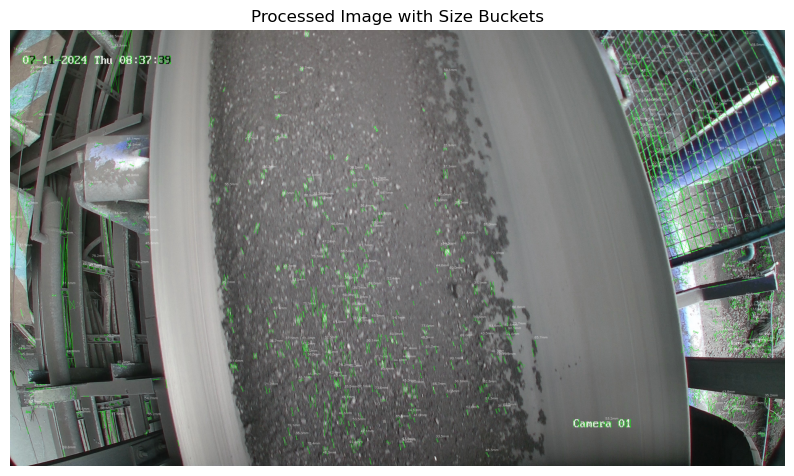

Size Buckets: {'0-6mm': 0, '6-8mm': 0, '8+mm': 898}


In [2]:
# Usage
image_file = 'rawan1_originalImage_2024-07-11_08-41-19.jpg'  # Use the correct image file path
processor = SimpleImageProcessor()
processor.process_image_file(image_file)

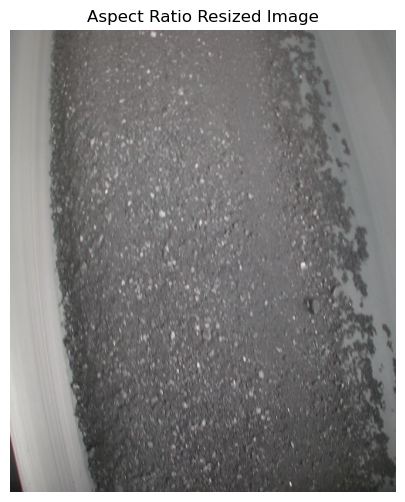

In [35]:
import cv2
import matplotlib.pyplot as plt

def resize_with_aspect_ratio(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Get the dimensions of the image
    (h, w) = image.shape[:2]
    dim = None

    # If both width and height are None, return the original image
    if width is None and height is None:
        return image

    # Calculate the target dimensions while preserving the aspect ratio
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    # Resize the image
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

# Load the image
image_path = 'rawan1_originalImage_2024-07-11_08-41-19.jpg'
image = cv2.imread(image_path)

# Resize the image while preserving aspect ratio
resized_image = resize_with_aspect_ratio(image[0:2500, 800:2600], height=600)  # Resize with max height of 600 pixels

# Display the resized image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Aspect Ratio Resized Image')
plt.axis('off')
plt.show()


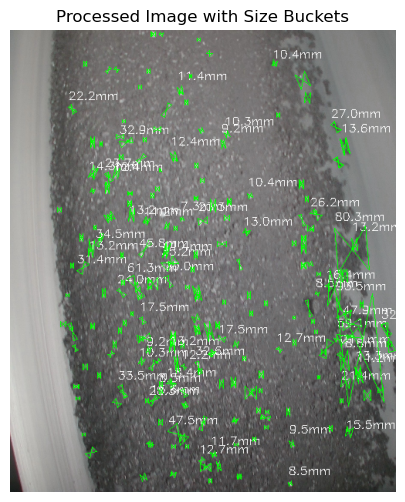

Size Buckets: {'0-6mm': 8, '6-8mm': 93, '8+mm': 187}


In [6]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

# Define the SimpleImageProcessor class
class SimpleImageProcessor:
    def __init__(self, reference_width=1.0, min_size=1, max_size=100):
        self.reference_width = reference_width
        self.min_size = min_size
        self.max_size = max_size

        self.bins = {
            '0-6mm': 0,
            '6-8mm': 0,
            '8+mm': 0
        }

    def midpoint(self, ptA, ptB):
        return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

    def image_preprocessing(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)
        processed = cv2.Canny(gray, 50, 100)
        processed = cv2.dilate(processed, None, iterations=1)
        processed = cv2.erode(processed, None, iterations=1)
        return processed

    def calculate_size(self, box, pixels_per_metric):
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = self.midpoint(tl, tr)
        (blbrX, blbrY) = self.midpoint(bl, br)
        (tlblX, tlblY) = self.midpoint(tl, bl)
        (trbrX, trbrY) = self.midpoint(tr, br)

        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        if pixels_per_metric is None and dB != 0:
            pixels_per_metric = dB / self.reference_width

        if pixels_per_metric is None or pixels_per_metric == 0:
            return (0, 0), pixels_per_metric  # Avoid division by zero

        dimA = dA / pixels_per_metric
        dimB = dB / pixels_per_metric

        return (dimA, dimB), pixels_per_metric

    def draw_and_label(self, image, box, dimensions):
        cv2.drawContours(image, [box.astype("int")], -1, (0, 255, 0), 1)
        dimA, dimB = dimensions
        if dimA > 0 and dimB > 0:
            cv2.putText(image, "{:.1f}mm".format(dimA), (int(box[0][0]), int(box[0][1] - 10)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        return image

    def classify_size(self, size):
        if size > 8:
            self.bins['8+mm'] += 1
        elif size > 6:
            self.bins['6-8mm'] += 1
        else:
            self.bins['0-6mm'] += 1

    def process_image(self, image):
        processed = self.image_preprocessing(image)  # Use the renamed function to avoid recursion

        cnts, _ = cv2.findContours(processed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        pixels_per_metric = None
        for c in cnts:
            if cv2.contourArea(c) < 10:  # Skip small contours
                continue

            box = cv2.minAreaRect(c)
            box = cv2.boxPoints(box)
            box = np.array(box, dtype="int")
            box = np.array(sorted(box, key=lambda x: (x[0], x[1])))  # Sort points for consistent order

            (dimA, dimB), pixels_per_metric = self.calculate_size(box, pixels_per_metric)

            if self.min_size < max(dimA, dimB) < self.max_size:
                self.classify_size(max(dimA, dimB))
                image = self.draw_and_label(image, box, (dimA, dimB))

        # Show the processed image with contours and labels
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Processed Image with Size Buckets')
        plt.axis('off')
        plt.show()

        print("Size Buckets:", self.bins)

# Define the function to resize an image with aspect ratio
def resize_with_aspect_ratio(image, width=None, height=None, inter=cv2.INTER_AREA):
    (h, w) = image.shape[:2]
    dim = None
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

image_path = 'rawan1_originalImage_2024-07-11_08-41-19.jpg'  
image = cv2.imread(image_path)
resized_image = resize_with_aspect_ratio(image[0:2500, 800:2600], height=600)

processor = SimpleImageProcessor()
processor.process_image(resized_image)
